# 综述
** 蓝色边缘程序(8582星表) **

_由于有一些星表中包含缺省项，我们需要使用pandas中使用dataframe读取csv中自动将缺省项补上的优势，来优化我们的自动化程式_

_(fits的文件我们可以使用topcat改变格式并且给星表瘦身，以加快程序读取速度）_

我们需要实现的功能包含以下几点：

输入：
* csv星表**_的名字_**
* 需要画的色指数的两个测光点（比如 $ J - H $ 我们需要输入$J$ 和 $H$）

程序中自带（我们所需要限定的条件）
_写在其中的某一个cell中作为 filt 条件_
* 去掉错误的点（见之前的程序)

输出：
* 颜色-teff 图

Now,trying:
* SFD: 一个新的ratio,比如说0.05，把这个ratio底下的部分输入进SFD,判断：E(B-V) <0.3 的值就是我们零消光的值。这个值去拟合一个新的curve。

# 数据的引入和format (Alternative)

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import datetime
from scipy.optimize import curve_fit
%matplotlib inline

data_dir = '/Users/SY/Desktop/obic/data/'
#data_dir = '/Users/dengdingshan/Documents/data/obic/'

In [2]:
#read as pandas
starcatalog_fram = pd.read_csv(data_dir + '8582_2mass.csv')

###########

#starcatlog_fram = starcatlog_fram.ix[:,:517]
#print(starcatalog_fram)

In [3]:
#read parsec
parsec_fram = pd.read_csv(data_dir + 'PARSEC2MASSandWISEPlus.csv')#PARSEC2MASSandWISEMinus PARSECGALEXandSDSSPlus

############

print(parsec_fram.columns)

Index(['Unnamed: 0', 'Zini', 'Age', 'Mini', 'Mass', 'logL', 'logTe', 'logg',
       'label', 'McoreTP', 'C_O', 'period0', 'period1', 'pmode', 'Mloss',
       'tau1m', 'X', 'Y', 'Xc', 'Xn', 'Xo', 'Cexcess', 'Z', 'mbolmag', 'Jmag',
       'Hmag', 'Ksmag', 'IRAC_3.6mag', 'IRAC_4.5mag', 'IRAC_5.8mag',
       'IRAC_8.0mag', 'MIPS_24mag', 'MIPS_70mag', 'MIPS_160mag', 'W1mag',
       'W2mag', 'W3mag', 'W4mag'],
      dtype='object')


In [4]:
### Elective CHOICE

########### I.
#change logTeff into Teff.

# def tenn(x):
#     y=10 ** x
#     return y

# Teff_tbl = starcatalog['logTeff'].apply(tenn)
###########

########### II.
#add [Teff] into DATAFRAME

#data_fram = starcatalog_fram[['TEFF_1','ERR_TEFF_1','Jmag_1','e_Jmag_1','Hmag_1','e_Hmag_1']]
#print(data_fram)
###########

########### III.
# fill the NaN blocks with 0

starcatalog_fram_fil0 = starcatalog_fram.fillna(0)

#print(starcatalog_fram_fil['LOGG'])
############
origin_1 = starcatalog_fram_fil0

In [5]:
starcatalog_fram.columns

Index(['RA', 'DEC', 'Teff_tlusty', 'logg_tlusty', '2MASS', 'RAJ2000',
       'DEJ2000', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'Jmag', 'Hmag',
       'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X', 'MeasureJD',
       'angDist'],
      dtype='object')

## 参数的选取（Input）

In [7]:
### variables

teff = 'Teff_tlusty'

color1 = 'Hmag'
color2 = 'Kmag'

err_c1 = 'e_' + color1
#'e_' + color1
#color1 + 'err' 
#color1 + 'err'
#ERR_' + color1
#'e_' + color1

err_c2 = 'e_' + color2 
#'ERR_' + color2
#'e_' + color2

## Logg，误差的选取(Input:)

In [8]:
### we just need the mainsquence (dwarf stars)

# #judge logg >3.0

Judge_logg = 3.5

starcatalog_fram_fil = starcatalog_fram_fil0[(starcatalog_fram_fil0['logg_tlusty']> Judge_logg)]
parsec_fram = parsec_fram[(parsec_fram['logg']>Judge_logg)]                                            

In [9]:
### get the good stars

# judge  data
starcatalog_fram_fil=starcatalog_fram_fil[((starcatalog_fram_fil[color1] != 0)\
                                           & (starcatalog_fram_fil[color2] != 0)\
                                           & (starcatalog_fram_fil[color1] != -99) \
                                           & (starcatalog_fram_fil[color2] != -99))\
                                         &((starcatalog_fram_fil[err_c1] <=0.03)\
                                          & (starcatalog_fram_fil[err_c2] <=0.03))]

starcatalog_fram_fil=starcatalog_fram_fil[((starcatalog_fram_fil['Jmag'] >= 5.5) \
                                           &(starcatalog_fram_fil['Hmag'] >= 5)\
                                           &(starcatalog_fram_fil['Kmag'] >= 4.5))]\
#                                            &(starcatalog_fram_fil['W1mag'] >= 8.1) \
#                                            &(starcatalog_fram_fil['W2mag'] >= 6.7)\
#                                            &(starcatalog_fram_fil['W3mag'] >= 3.8))]
# ### additional judgement

# starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil[err_c1] <=0.2)\
#                                            &(starcatalog_fram_fil[err_c2] <=0.05)]

# print(starcatalog_fram_fil.iloc[:,0].size)

## 赫罗图的限制——Only for SDSS

In [30]:
# Only for SDSS
# for H-R gragh

# if want to use this section, 
# just choose the part between 2 ### and use [command+/]
################

origin = starcatalog_fram_fil
# # starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil[color1]-starcatalog_fram_fil[color2]>= -0.50)\
# #                                          & (starcatalog_fram_fil[color1]>=14)]


data_final_sdss = starcatalog_fram_fil[(\
                                   (starcatalog_fram_fil[color1] > 14)\
                                   & (starcatalog_fram_fil[color2] > 14))]

#data_final_sdss = data_final_sdss[( (data_final_sdss[color1] - data_final_sdss[color2]) > -0.5)]

starcatalog_fram_fil = data_final_sdss

#################

## 有效温度 Teff 的限制（Input:）

In [10]:
#filt the good one
#apogee_tbl_fil = apogee_tbl[np.argwhere(np.logical_and(apogee_tbl['teff'] > 0, apogee_tbl['logg'] > -3))]
#apogee_tbl_fil = apogee_tbl_fil[np.argwhere(np.logical_and(apogee_tbl_fil['j'].flatten() > -1, \
#                                                           apogee_tbl_fil['h'].flatten() > -1))]
#USE goodOB 


starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil[teff]>= 10000)]

print(np.max(starcatalog_fram_fil[teff]))
print(starcatalog_fram_fil.iloc[:,0].size)

36367.79531
6116


## 蓝色边缘的比例，bin最小值的选取（Input：）

In [11]:
# Determine the input numbers.

# Bin width, usually 50 (for more scatter, try 1000 or other figures)
#bin_width = 1000

# Ratio of the bluest edge, usually 5%
rat = 5

# Low end criteria. If the number in a bin is lower than this number then neglect.  
low_crit = 50

In [12]:
# input the data of Bessell. M.S. & Brett. J.M. 1988
# BBFrame is the dataframe of the ic data 

BBFrame=pd.DataFrame({'J-H':[-0.09,-0.08,-0.07,-0.06,-0.05,-0.03,-0.03,-0.01,0.0,0.02,0.06],\
                      'Teff':[22300,19000,17200,15400,14100,13000,11800,10700,9480,8810,8160]})


## 比较星表的数据选取（Input:）

In [13]:
# parsec point
parsecframe = parsec_fram[((parsec_fram['logTe'] <= 4.361)\
                           &(parsec_fram['logTe'] >= 4))]

# print(parsecframe.values)
                                         

In [15]:
bin_width_par = 500
teff_start_par = 10000
teff_end_par = 30000

color_total = []
teff_total = []
for i in range(int((teff_end_par-teff_start_par)/bin_width_par)):
    parsecframe_bin = parsecframe[( (teff_start_par+i*bin_width_par) <=10**parsecframe['logTe']) & \
                (10**parsecframe['logTe']< (teff_start_par+ (i+1)*bin_width_par) )]
    color_total.append(np.median(np.array(parsecframe_bin[color1]-parsecframe_bin['Ksmag'])))#'Ksmag'
    teff_total.append(teff_start_par+(i+0.5)*bin_width_par)
    
parsec_color = np.array(color_total)
parsec_teff = np.array(teff_total)

/Users/SY/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/SY/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
# Find the start point and bin number of Teff. 
# Start point: the first number divisible by bin_width smaller than min(teff)
# Bin number: Start from start point and cover all the teff range.


#teff_start = min(apogee_tbl_fil['teff']) - min(apogee_tbl_fil['teff']) % (bin_width/2)
#bin_number = math.ceil((max(apogee_tbl_fil['teff']) - teff_start) / bin_width)

#teff_start = min(starcatalog_fram_fil[teff])-min(starcatalog_fram_fil[teff])%(bin_width / 2)

teff_start= 10000
slide_index = 400 #the pace of slide
#bin_number = math.ceil((max(starcatalog_fram_fil[teff])-teff_start) / bin_width)


In [17]:
#filt BBFrame
BBFrame_fil=BBFrame[BBFrame['Teff'] >= teff_start]

# 内禀色指数的计算（蓝色边缘方法），同时取出某一部分用于SFD判断

## DEF

In [18]:
def data(teff_start,ratio,low_crit,ratio_SFD,slide_index):
    
    start_time = time.time()
    int_teff = []
    int_color = []
    bin_int_color = []
    
    SFD_RA = []; SFD_DEC = []; SFD_TEFF = []; SFD_color1 = []; SFD_color2 = [];
    
    data_final = pd.DataFrame(columns=[teff,color1,color2])
    teff_judge = teff_start
    while teff_judge < np.max(starcatalog_fram_fil[teff]) - 2000:
        #print(teff_judge)
        if teff_judge <15000:
            bin_width = 500
        else:
            bin_width = 2000

        bin_tbl =starcatalog_fram_fil[np.logical_and(starcatalog_fram_fil[teff] > teff_judge, \
                                                starcatalog_fram_fil[teff] < teff_judge+bin_width)]

        #print(teff_judge)
       
        
        if len(bin_tbl) < low_crit:
            teff_judge = teff_judge+slide_index
            #print('1')
            continue
            
        source_num = 0
        #print(len(bin_tbl))

        while source_num != len(bin_tbl):
            source_num = len(bin_tbl)

        data_final = data_final.append(bin_tbl[[teff,color1,color2]])
        #print(len(bin_tbl))

        int_teff.append(float(teff_judge+bin_width/2))
        bin_tbl['color'] = bin_tbl[color1]-bin_tbl[color2]
        bin_sort = bin_tbl.sort_index(axis = 0,ascending = True,by = 'color')
        
        # 每个bin中前ratio_SFD的部分用于取得ebv
        color_SFD = bin_sort['color'].values[:math.ceil(len(bin_tbl)*ratio_SFD/100)]
        bin_tbl_SFD = bin_sort[(bin_sort['color']<=np.max(color_SFD))]
        
        for ppp in range(len(bin_tbl_SFD)):
            SFD_RA.append(bin_tbl_SFD['RA'].values[ppp])
            SFD_DEC.append(bin_tbl_SFD['DEC'].values[ppp])
            SFD_TEFF.append(bin_tbl_SFD[teff].values[ppp])
            SFD_color1.append(bin_tbl_SFD[color1].values[ppp])
            SFD_color2.append(bin_tbl_SFD[color2].values[ppp])

        
        # 每个bin中前ratio(usually 5%)的部分 用于取得内禀色指数int_color
        color5 = bin_sort['color'].values[:math.ceil(len(bin_tbl)*ratio/100)]
        bin_tbl_5 = bin_sort[(bin_sort['color']<=np.max(color5))]
        
        
        if len(color5) != 0:
            for i in range(10):
                bin_mean = np.median(color5)
                bin_sigma = np.std(color5)
                bin_int_color = color5\
                [((color5<= bin_mean+3*bin_sigma)\
                & (color5>= bin_mean-3*bin_sigma))]
                color5 = np.array(bin_int_color)

            int_color.append(np.median(bin_int_color))
            
        teff_judge = teff_judge+slide_index
        
    SFD_tbl_final = pd.DataFrame({teff:np.array(SFD_TEFF),'RA':np.array(SFD_RA),\
                                  'DEC':np.array(SFD_DEC),color1:np.array(SFD_color1),\
                                 color2:np.array(SFD_color2)})
    
    #print(time.time() - start_time)
    print(int_teff,int_color)
#     print(bin_mean)
#     print(data_final.iloc[:,0].size)
    return int_teff,int_color,data_final,SFD_tbl_final

## 运算，拟合，SFD的准备（Input:)

In [35]:
# SFD ratio

ratio_SFD = 5

# fitting curve
int_teff,int_color,data_final,SFD_tbl_ratio = data(teff_start,rat,low_crit,ratio_SFD,slide_index)
int_teff_fit = list(np.array(int_teff)/10000)

def func(x, a, b, c):
    return a * np.exp(-b * x) + c
print(int_teff_fit)

popt, pcov = curve_fit(func, int_teff_fit, int_color)
#popt数组中，三个值分别是待求参数a,b,c
colorvals = [func(i, popt[0],popt[1],popt[2]) for i in int_teff_fit]

print(colorvals)
print(str(popt[0])+'* np.exp('+str(-popt[1])+'*x)'+str(popt[2]))#在屏幕上打印拟合多项式 
# fc = np.polyfit(int_teff, int_color, 1)#用3次多项式拟合
# fitcurve = np.poly1d(fc)
# print(fitcurve) #在屏幕上打印拟合多项式

# colorvals=fitcurve(int_teff)

# print(len(colorvals),len(int_teff))
#print(len(bin_tbl_final[teff].values))

#SFD_tbl_ratio['SFD_ebv']


/Users/SY/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/SY/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


[10250.0, 10650.0, 11050.0, 11450.0, 11850.0, 12250.0, 12650.0, 13050.0, 13450.0, 13850.0, 14250.0, 14650.0, 15050.0, 16200.0, 16600.0, 17000.0, 17400.0, 17800.0, 18200.0, 18600.0, 19000.0, 19400.0, 19800.0, 20200.0, 20600.0, 21000.0, 21400.0, 21800.0, 22200.0, 22600.0, 23000.0, 23400.0, 23800.0, 24200.0, 24600.0, 25000.0, 25400.0, 25800.0, 26200.0, 26600.0, 27000.0, 27400.0, 27800.0, 28200.0, 28600.0] [-0.023999999999997357, -0.018999999999998352, -0.019999999999999574, -0.035000000000000142, -0.035000000000000142, -0.031500000000002082, -0.029499999999999638, -0.026000000000000689, -0.035000000000000142, -0.019500000000000739, -0.01899999999999924, -0.032499999999998863, -0.024000000000000909, -0.022999999999999687, -0.023999999999999133, -0.020999999999999908, -0.022999999999999687, -0.026999999999999247, -0.024499999999999744, -0.020999999999999908, -0.026000000000000689, -0.028000000000000469, -0.028499999999999304, -0.028000000000000469, -0.028000000000000469, -0.0179999999999989

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

# SFD的使用：—— 将使用到新的包

1. 选取SFD中Ebv小于某一个值的认为是零消光源（Lamost)——Thins page
2. 用目前的色指数减去 Ebv 给出的消光值，然后去归算内禀色指数 - GOSSS

In [24]:
# SFD_catalog_color = []
# SFD_catalog_teff = []
# lens = len(SFD_tbl_ratio)

# for i in range(lens):
#     if SFD_tbl_ratio['SFD_ebv'].values[i] < 0.05:
#         SFD_colorindex = SFD_tbl_ratio[color1].values[i]\
#         - (SFD_tbl_ratio[color2].values[i])
#         SFD_catalog_color.append(SFD_colorindex)
    
#         SFD_catalog_teff.append(SFD_tbl_ratio[teff].values[i])
#         print(i)
# #     print(i)

# # print(time.time() - time_start)

In [25]:
## use SFD dustmap
from __future__ import print_function
from astropy.coordinates import SkyCoord
from astropy import units as u
from dustmaps.sfd import SFDQuery

sfd = SFDQuery()

## ebv前的系数需要去文献中拿到。目前使用的是r和i的
# Const1 = 0.709 #J #3.303 #g #2.285 #r 
# Const2 = 0.449 #H #2.285 #r #1.698 #i

time_start = time.time()
SFD_catalog_color = []
SFD_catalog_teff = []
lens = len(SFD_tbl_ratio)

ebv_final = []

# 判断ebv < 0.05，就拿入下一个数组，最后一起画在图上
print(lens)
for i in range(lens):
    coords = SkyCoord(SFD_tbl_ratio['RA'].values[i],SFD_tbl_ratio['DEC'].values[i],\
                      frame = 'icrs',unit = 'deg')
    ebv = sfd(coords)
    ebv_final.append(ebv)
    
#     A_c1 = Const1*ebv;
#     A_c2 = Const2*ebv;

    if ebv < 0.05:
        SFD_colorindex = SFD_tbl_ratio[color1].values[i]\
        - (SFD_tbl_ratio[color2].values[i])
        SFD_catalog_color.append(SFD_colorindex)
    
        SFD_catalog_teff.append(SFD_tbl_ratio[teff].values[i])
        print(i)
#     print(i)
SFD_catalog_teff_fit = list(np.array(SFD_catalog_teff)/5000)
print(time.time() - time_start)

647
3
7
16
45
109
113
121
122
125
130
144
155
161
175
180
215
217
221
236
248
249
253
268
279
281
286
298
309
311
316
328
336
343
354
583
591
598
605
611
81.30631399154663


# 图片输出

## 图片保存格式（Input:)

In [26]:
### figures & Savename
cc1 = 'H'
cc2 = 'Ks'

save = data_dir + 'pictures/'
# save = '/Users/SY/Desktop/obic/picture/'

i = datetime.datetime.now()
date_now = "%s_%s_%s_" % (i.year, i.month, i.day) 
ylabel = '$%s - %s$'%(cc1,cc2) 
savename1 = save + date_now + cc1 + cc2 + '8582'+'.png'
savename2 = save + date_now + 'logg_teff_8582'+'.png'
# savename3 = save + date_now + 'errteff.png'

# savename5 = save + date_now + cc1 + cc2 + 'FEH'+'Plus'+'.png'
# savename6 = save + date_now + cc1 + cc2 + 'FEH'+'Plus'+'_sdssno'+'.png'

In [27]:
# plt hist of ebv

# plt.hist(ebv_final,1000)
# plt.savefig(save+'ebv.png',dpi = 200)
# plt.xlim(0,2)
# plt.show()

# 拟合SFD
 

popt_sfd, pcov_sfd = curve_fit(func, SFD_catalog_teff_fit, SFD_catalog_color)
#popt数组中，三个值分别是待求参数a,b,c
SFD_vals = [func(i, popt_sfd[0],popt_sfd[1],popt_sfd[2]) for i in SFD_catalog_teff_fit]


print(SFD_catalog_teff)
print(str(popt_sfd[0])+'* np.exp('+str(-popt_sfd[1])+'*x)'+str(popt_sfd[2])) #在屏幕上打印拟合多项式

# fc = np.polyfit(SFD_catalog_teff, SFD_catalog_color, 1)#用3次多项式拟合
# fitcurve = np.poly1d(fc)
# print(fitcurve) #在屏幕上打印拟合多项式
# SFD_vals=fitcurve(SFD_catalog_teff)


[10000.038, 10000.06465, 10000.099909999999, 10537.20493, 13212.63847, 13099.279709999999, 13462.65344, 13614.238590000001, 13212.63847, 13614.238590000001, 14359.6167, 14524.115250000001, 14623.577430000001, 15033.354130000002, 17131.362450000001, 17331.283719999999, 17131.362450000001, 17247.031769999998, 17520.267769999999, 17331.283719999999, 17131.362450000001, 17247.031769999998, 17520.267769999999, 17331.283719999999, 17131.362450000001, 17247.031769999998, 17520.267769999999, 17331.283719999999, 17131.362450000001, 17247.031769999998, 17520.267769999999, 17331.283719999999, 17247.031769999998, 17520.267769999999, 25142.127090000002, 25142.127090000002, 25142.127090000002, 25142.127090000002, 25142.127090000002]
-19.0598899131* np.exp(-22.7302306581*x)-0.0525128205128


/Users/SY/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## 绘图所需的具体量（Alternative)

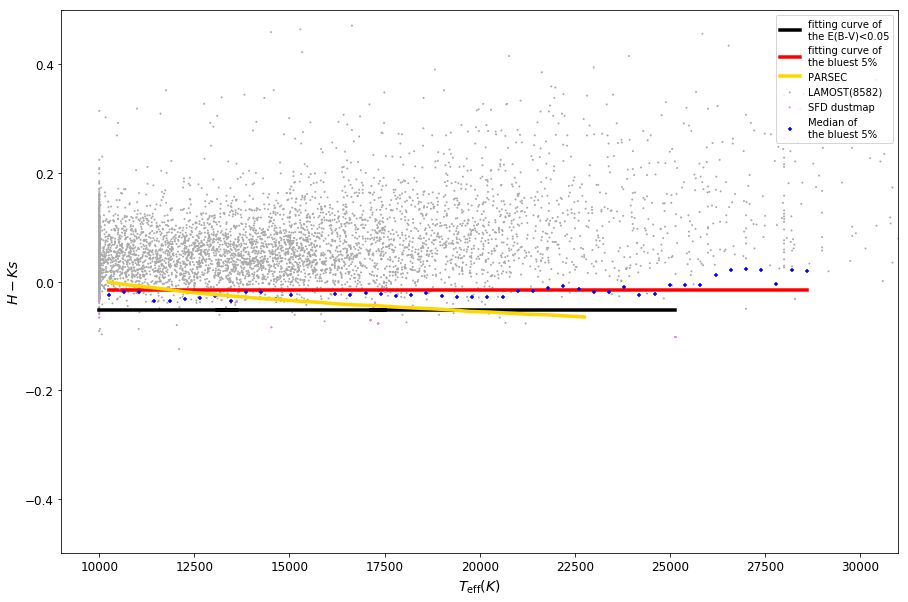

In [34]:
#PLT
plt.figure(1,figsize=(15, 10))  
plt.xlabel('$T_\mathrm{eff}(K)$',fontsize=14)
plt.ylabel(ylabel,fontsize=14)

# the data we use
plt.scatter(starcatalog_fram_fil[teff], starcatalog_fram_fil[color1]-starcatalog_fram_fil[color2],\
            c='darkgray',s=4, edgecolors='None',label='LAMOST(8582)')

# data we use in the SFD dustmap
plt.scatter(SFD_catalog_teff,SFD_catalog_color,alpha=1,edgecolors='None',c='violet',s=4,label='SFD dustmap',zorder=2)

# SFD fitcurve
plt.plot(SFD_catalog_teff, SFD_vals, c='black',linewidth = 3.5,label='fitting curve of \nthe E(B-V)<0.05',zorder=1)

# ic plot from blue edge
plt.plot(int_teff, colorvals, c='r',linewidth = 3.5,label='fitting curve of \nthe bluest 5%',zorder=1,alpha=1)

# ic from blue edge
plt.scatter(int_teff, int_color, edgecolors='None',c='b', marker = '+',s=11,label='Median of\nthe bluest 5%',zorder=2)

# ic from Allen's work 
# plt.scatter(BBFrame_fil['Teff'],BBFrame_fil['J-H'],c='lime',s=11,label='Allen',zorder=2)

#ic from parsec
#plt.scatter(parsec_teff,parsec_color,c='gold',s=5,label='PARSEC',zorder=2)
plt.plot(parsec_teff, parsec_color, c='gold',linewidth = 3.5,label='PARSEC',zorder=2,alpha=1)
### Draw the plot

# plt.xlabel('$T_\mathrm{eff}$'); plt.ylabel(ylabel)
#plt.scatter(BBFrame_fil['Teff'],BBFrame_fil['J-H'],c='lightgreen',s=15,label='Allen')

plt.legend(loc='upper right')
#new_ticks = np.linspace(-1,2,7)
#plt.yticks(new_ticks)

# plt.ylim(np.min(starcatalog_fram_fil[color1] - starcatalog_fram_fil[color2]) - 0.5,\
#         np.max(starcatalog_fram_fil[color1] - starcatalog_fram_fil[color2]))
#plt.ylim(np.min(starcatalog_fram_fil[color1] - starcatalog_fram_fil[color2]) - 0.5,\
#       4)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig(savename1,dpi=200)
plt.xlim(9000,31000)
plt.ylim(-0.5,0.5)
plt.savefig(savename1,dpi=200)

plt.show()

In [68]:
parsec_teff

array([ 10250.,  10750.,  11250.,  11750.,  12250.,  12750.,  13250.,
        13750.,  14250.,  14750.,  15250.,  15750.,  16250.,  16750.,
        17250.,  17750.,  18250.,  18750.,  19250.,  19750.,  20250.,
        20750.,  21250.,  21750.,  22250.,  22750.,  23250.,  23750.,
        24250.,  24750.,  25250.,  25750.,  26250.,  26750.,  27250.,
        27750.,  28250.,  28750.,  29250.,  29750.])

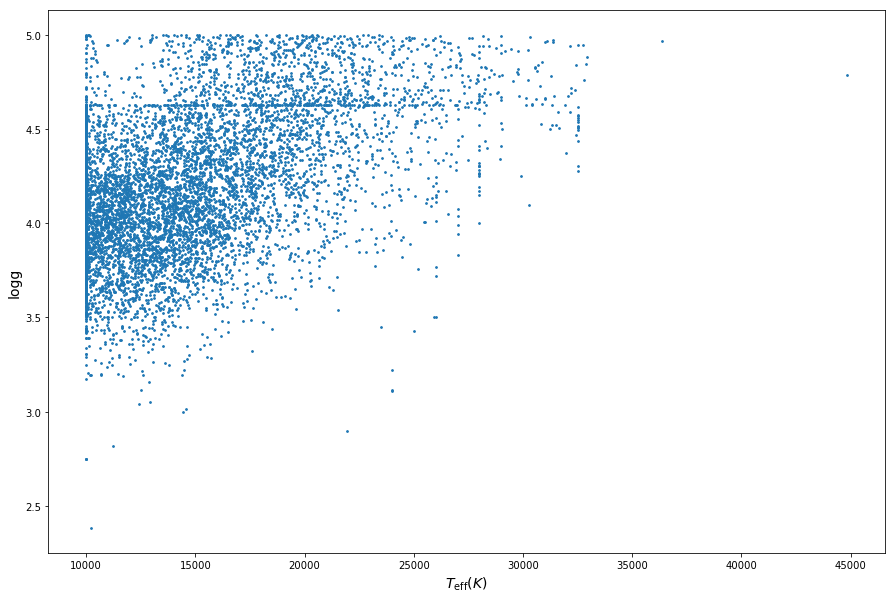

In [71]:
TEFF = origin_1['Teff_tlusty'].values
logg = origin_1['logg_tlusty'].values


plt.figure(2,figsize=(15, 10))  
plt.xlabel('$T_\mathrm{eff}(K)$',fontsize=14)
plt.ylabel('logg',fontsize=14)

plt.scatter(TEFF,logg,s=3)
plt.savefig(savename2,dpi=200)
plt.show()



